# opinet experiments
This notebook runs simulations in the opinet framework. 

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from graphs import complete_graph, gnp_graph, barabasi_albert_graph
from util import convergence_time, run_sharing_experiment, run_following_experiment
from evolve import run_evolving_experiment
from visualize import plot_graph

In [63]:
# set up plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
matplotlib.rcParams['axes.titlesize'] = 32
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.style.use(u'seaborn-darkgrid')
sns.set_style('darkgrid')
sns.set_palette('muted')
palette = current_palette = sns.color_palette().as_hex()

## Experiment definitions
First we define functions to run experiments for each variable of interest.

In [66]:
def sharing_convergence():
    """
    Dependent variables: 
        1) average stance in convergence
        2) rounds (time steps) before convergence
    Independent variables:
        1) graph structure, size, and average degree
        2) impressionability (beta parameter)
    Controlling:
        1) truthful sharing 
    """
    ### game parameters
    # graph
    n_list = [1000]
    avg_degree = 50
    
    # personalities
    beta_list = list(np.arange(0.0, 1, 0.05))   

    # fixed experiment parameters
    convergence_eps = 0.01
    T = 20
    strategies = 'truthful'
    n_trials = 10
    n_topologies = 3

    ### results
    convergence_times = np.empty((len(n_list), len(beta_list), n_topologies, n_trials))
    avg_stance_complete = np.empty((len(n_list), len(beta_list), n_topologies, n_trials))
    var_stance_complete = np.empty((len(n_list), len(beta_list), n_topologies, n_trials))

    ### simulate
    for n_idx, n in enumerate(n_list):
        alphas, gammas = [-1.0] * n, [lambda R: 0.0 * R] * n
        for b_idx, b in enumerate(beta_list):
            for t_idx in range(n_trials):
                # generate instances
                init_stances = np.random.uniform(low=-1, high=1, size=n)
                betas = [b] * n

                E_mat_complete = complete_graph(n)
                E_mat_gnp = gnp_graph(n, avg_degree)
                E_mat_ba = barabasi_albert_graph(n, avg_degree)

                graphs_list = [E_mat_complete, E_mat_gnp, E_mat_ba]
                for g_idx, graph in enumerate(graphs_list):
                    stances, _, _ = run_sharing_experiment(init_stances, alphas, betas, gammas, strategies, T, graph)
                    convergence_times[n_idx, b_idx, g_idx, t_idx] = convergence_time(stances, convergence_eps)
                    avg_stance_complete[n_idx, b_idx, g_idx, t_idx] = np.mean(stances[-1])
                    var_stance_complete[n_idx, b_idx, g_idx, t_idx] = np.std(stances[-1])

    return avg_stance_complete, var_stance_complete, convergence_times

In [4]:
def sharing_optimality():
    """
    Dependent variables: 
        1) utility
    Independent variables:
        1) sharing strategy
    Controlling:
        1) personalities (alpha, beta, gamma)
        2) graph structure, size, and average degree
    """
    ### game parameters
    # graph
    n_list = [100,]
    avg_degree_list = [10,50]
    
    # personalities
    a = -1
    b = 0.5
    g = 1
    
    # strategies
    strategies_list = ['truthful', 'extreme']
    
    # fixed experiment parameters
    n_trials = 30
    T = 30
    n_topologies = 3
    
    ### results
    avg_utilities = np.empty((len(n_list), len(avg_degree_list), n_topologies, len(strategies_list), n_trials))

    ### simulate
    for n_idx, n in enumerate(n_list):
        alphas, betas, gammas = [a] * n, [b] * n, [lambda R: g * R] * n
        for d_idx, d in enumerate(avg_degree_list):    
            for t_idx in range(n_trials): 
                # generate graph instances
                init_stances = np.random.uniform(low=-1, high=1, size=n)
                E_mat_complete = complete_graph(n)
                E_mat_gnp = gnp_graph(n, d)
                E_mat_ba = barabasi_albert_graph(n, d)
                graph_list = [E_mat_complete, E_mat_gnp, E_mat_ba]

                for g_idx, graph in enumerate(graph_list):
                    for strategy_idx, strategy in enumerate(strategies_list):
                        # try all strategies
                        stances, actions, utilities = run_sharing_experiment(init_stances, alphas, betas, gammas, 
                                                                             strategy, T, graph)
                        avg_utilities[n_idx, d_idx, g_idx, strategy_idx, t_idx] = np.mean(utilities)

    return avg_utilities

In [5]:
def sharing_evolution():
    """
    Formulate a linear sharing strategy as
        s = diff_mult * (average stance difference) + stance_mult * current stance
        
    Run sequential sharing games. Proceed as follows.
        1) In the first round t=1, uniformly initialize values of diff_mult and stance_mult.
        2) In subsequent rounds t>1, agents in round t-1 birth new agents proportional to their utility in round t-1.
        3) Repeat the sharing and birthing process.
        
    Controlling:
        1) personalities (alpha, beta, gamma)
        2) graph structure, size, and average degree
    """
    ### game parameters
    # graph
    n = 50
    avg_degree = 5
    
    # personalities
    a = -0.5
    b = 0.2
    g = 0.1
    
    # fixed experiment parameters
    T = 20 
    n_rounds = 1000
    n_trials = 10 
    n_topologies = 3
    
    ### results
    avg_utilities = np.empty((n_topologies, n_trials, n_rounds))
    avg_stance_mults = np.empty((n_topologies, n_trials, n_rounds))
    avg_diff_mults = np.empty((n_topologies, n_trials, n_rounds))

    ### simulate
    alphas, betas, gammas = [a] * n, [b] * n, [lambda R: g * R] * n
    for t_idx in range(n_trials): 
        # generate graph instances
        init_stances = np.random.uniform(low=-1, high=1, size=n)
        E_mat_complete = complete_graph(n)
        E_mat_gnp = gnp_graph(n, avg_degree)
        E_mat_ba = barabasi_albert_graph(n, avg_degree)
        graph_list = [E_mat_complete, E_mat_gnp, E_mat_ba]

        for g_idx, graph in enumerate(graph_list):
            utilities, stance_mults, diff_mults = run_evolving_experiment(init_stances, alphas, betas, gammas, 
                                                                          'linear', T, graph, n_rounds, 
                                                                          initialization='uniform', 
                                                                          mutation_rate=0.05)
            avg_utilities[g_idx, t_idx] = utilities
            avg_stance_mults[g_idx, t_idx] = stance_mults
            avg_diff_mults[g_idx, t_idx] = diff_mults

    return avg_utilities, avg_stance_mults, avg_diff_mults

In [6]:
def following_convergence():
    """
    Dependent variables: 
        1) long-run graph structure
        2) stances
    Independent variables:
        1) initial opinions, graph structure, size, and average degree
            Initial structures:
                a) Complete
                b) Complete connected components
                c) E-R
                d) B-A
            Initial opinions:
                a) Extremes
                b) Uniform
    Controlling:
        1) personalities (alpha, beta, gamma)
        2) approximately optimal sharing strategies
    """
    ### game parameters
    # graph
    n = 8
    avg_degree = 5
    
    # personalities
    a = -1
    b = 0.01
    g = 0.15
    alphas, betas, gammas = [a] * n, [b] * n, [lambda R: g * R] * n
    
    # fixed experiment parameters
    T = 30
    n_trials = 1
    n_topologies = 4
    n_init_stances = 2
    
    ### results
    Gs = np.empty((n_topologies, n_init_stances, n_trials, T, n, n))
    final_stances = np.empty((n_topologies, n_init_stances, n_trials, n))
    
    ### simulate           
    for t_idx in range(n_trials): 
        ## generate graph instances
        # complete graph
        E_mat_complete = complete_graph(n)
        
        # completely connected components
        assert(n % 2 == 0)
        half_n = n / 2
        ones_quadrant = np.ones((half_n, half_n))
        zeros_quadrant = np.zeros((half_n, half_n))
        upper = np.hstack((ones_quadrant, zeros_quadrant))
        lower = np.hstack((zeros_quadrant, ones_quadrant))
        E_mat_CC = np.vstack((upper, lower))
        np.fill_diagonal(E_mat_CC, 0)
        
        # G(n,p)
        E_mat_gnp = gnp_graph(n, avg_degree)
        
        # Barabsi-Albert
        E_mat_ba = barabasi_albert_graph(n, avg_degree)
        
        ## initial stances
        # uniform
        init_stances_unif = np.random.uniform(low=-1, high=1, size=n)
        
        # random extreme: half -1s, half 1s
        ordered = np.hstack((np.ones(half_n), -np.ones(n - half_n)))
        init_stances_extreme = np.random.permutation(ordered)
        
        graph_list = [E_mat_complete, E_mat_CC, E_mat_gnp, E_mat_ba]
        stances_list = [init_stances_unif, init_stances_extreme]
        
        # run for each set of initial conditions
        for g_idx, graph in enumerate(graph_list):
            for s_idx, init_stances in enumerate(stances_list):
                stances, G, _ = run_following_experiment(init_stances, alphas, betas, gammas, 'approx_opt', T, graph,
                                                         calc_utilities=True, keep_G=True)

                Gs[g_idx, s_idx, t_idx] = G
                final_stances[g_idx, s_idx, t_idx] = stances[-1]
                
        # check stability of party system
#         stable_gammas = [lambda R: 0.0 * R] * n
#         stances, G, _ = run_following_experiment(ordered, alphas, betas, stable_gammas, 'approx_opt', T, E_mat_CC, 
#                                                  calc_utilities=False, keep_G=False)
#         G[np.isnan(G)] = 0
#         assert(np.array_equal(G, E_mat_CC))
#         assert(np.array_equal(stances[-1], ordered))

    return Gs, final_stances

## Run experiments and visualize
We now run the experiments defined above and plot the results.

---

### Sharing Convergence

In [67]:
stances, var_stances, convergence_times = sharing_convergence()
avg_stances, avg_vars, avg_convergence_times = np.mean(stances, axis=-1), np.mean(var_stances, axis=-1), \
                                               np.mean(convergence_times, axis=-1)

[]

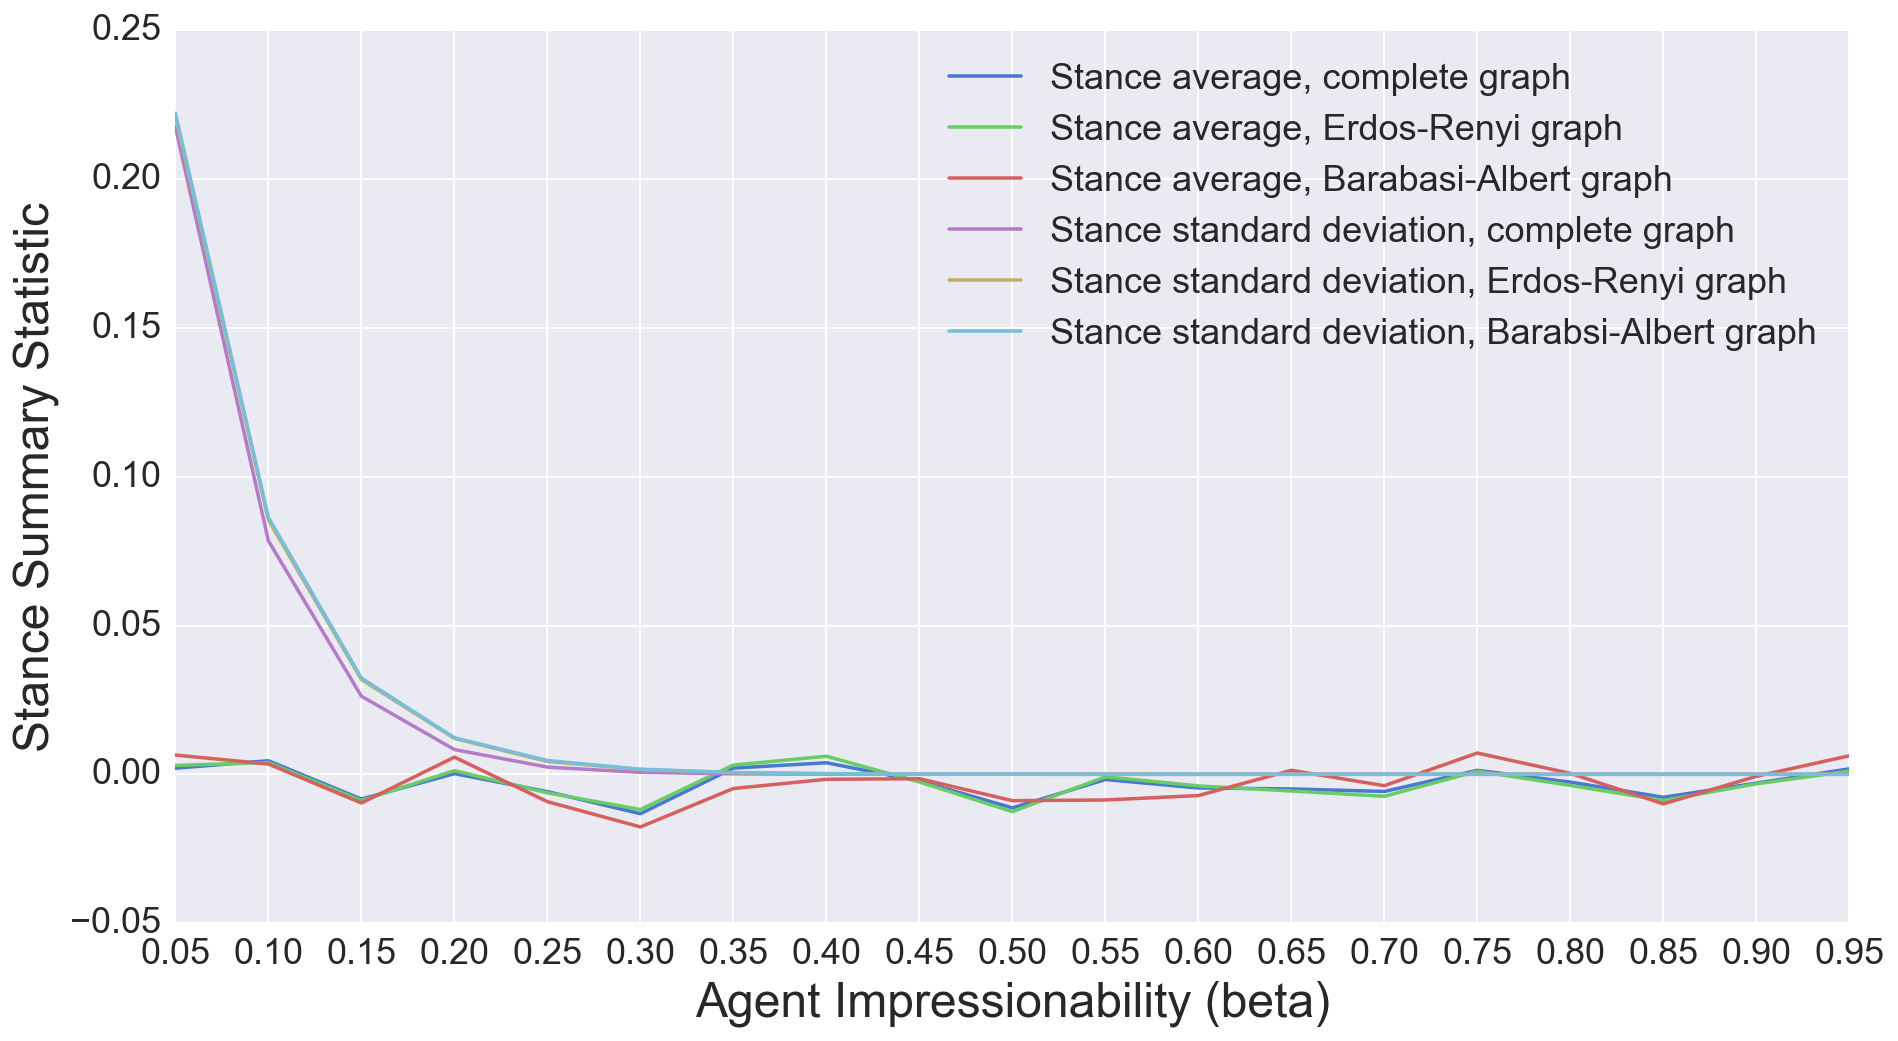

In [72]:
# Graph
bs = np.arange(0.05, 1, 0.05)
plt.plot(bs, avg_stances[0,:,0][1:], label='Stance average, complete graph')
plt.plot(bs, avg_stances[0,:,1][1:], label='Stance average, Erdos-Renyi graph')
plt.plot(bs, avg_stances[0,:,2][1:], label='Stance average, Barabasi-Albert graph')
plt.plot(bs, avg_vars[0,:,0][1:], label='Stance standard deviation, complete graph')
plt.plot(bs, avg_vars[0,:,1][1:], label='Stance standard deviation, Erdos-Renyi graph')
plt.plot(bs, avg_vars[0,:,2][1:], label='Stance standard deviation, Barabsi-Albert graph')
plt.legend()
plt.xticks(bs)
plt.xlabel('Agent Impressionability (beta)')
plt.ylabel('Stance Summary Statistic')
plt.plot()

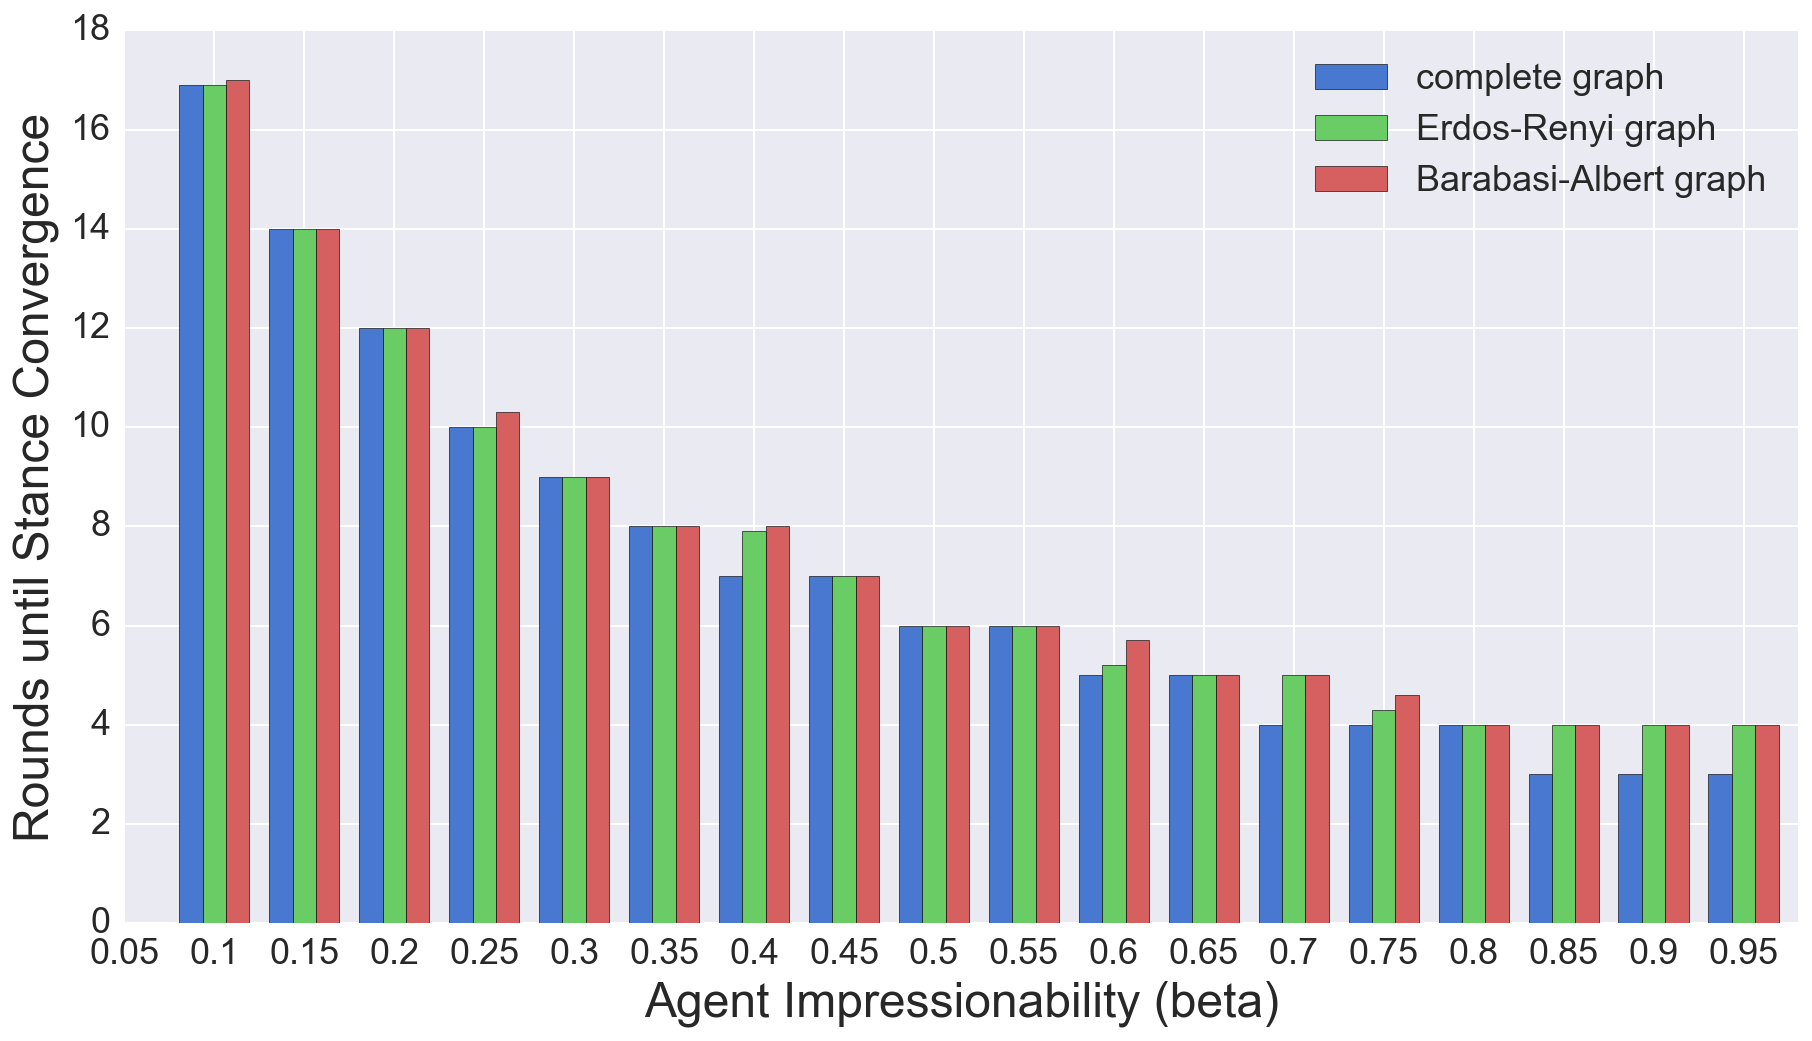

In [74]:
bar_width = 0.013
 
rects1 = plt.bar(bs, avg_convergence_times[0,:,0][1:], bar_width, color=palette[0], label='complete graph')
rects1 = plt.bar(bs + bar_width, avg_convergence_times[0,:,1][1:], bar_width, color=palette[1], label='Erdos-Renyi graph')
rects1 = plt.bar(bs + 2 * bar_width, avg_convergence_times[0,:,2][1:], bar_width, color=palette[2], label='Barabasi-Albert graph')
 
plt.xlabel('Agent Impressionability (beta)')
plt.ylabel('Rounds until Stance Convergence')
plt.xticks(bs + 1.5 * bar_width, bs)
plt.legend()
plt.show()

---

### Evolving Sharing Strategies

In [27]:
utilities, stance_mults, diff_mults = sharing_evolution()
avg_utilities, avg_stance_mults, avg_diff_mults = np.mean(utilities, axis=-2), np.mean(stance_mults, axis=-2), \
                                                  np.mean(diff_mults, axis=-2)

KeyboardInterrupt: 

In [26]:
stance_complete, = plt.plot(avg_stance_mults[0], label="Stance multiple, complete graph")
diff_complete, = plt.plot(avg_diff_mults[0], label="Difference multiple, complete graph")
stance_gnp, = plt.plot(avg_stance_mults[1], label="Stance multiple, Erdos-Renyi graph")
diff_gnp, = plt.plot(avg_diff_mults[1], label="Difference multiple, Erdos-Renyi graph")
stance_ba, = plt.plot(avg_stance_mults[2], label="Stance multiple, Barabasi-Albert graph")
diff_ba, = plt.plot(avg_diff_mults[2], label="Stance multiple, Barabasi-Albert graph")
plt.ylabel("Strategy Parameter Value")
plt.xlabel("Round of Game")
plt.legend(handles=[stance_complete, stance_gnp, stance_ba, diff_complete, diff_gnp,  diff_ba], loc=2)
plt.show()

NameError: name 'avg_stance_mults' is not defined

---

### Following Convergence

In [ ]:
Gs, final_stances = following_convergence()

In [ ]:
# create animations
G_plots = plot_dynamic_graph(G, "fun_video", stances=stances, actions=stances, scale_nodes="outdegree", margin=50)

In [16]:
avg_utilities = sharing_optimality()
avg_utilities, stance_mults, diff_mults = sharing_evolution()
p, g, s = plot_graph(Gs[1,0,0], stances=stances[1,0,0], actions=stances[1,0,0], scale_nodes="outdegree", margin=40, file_name="example")

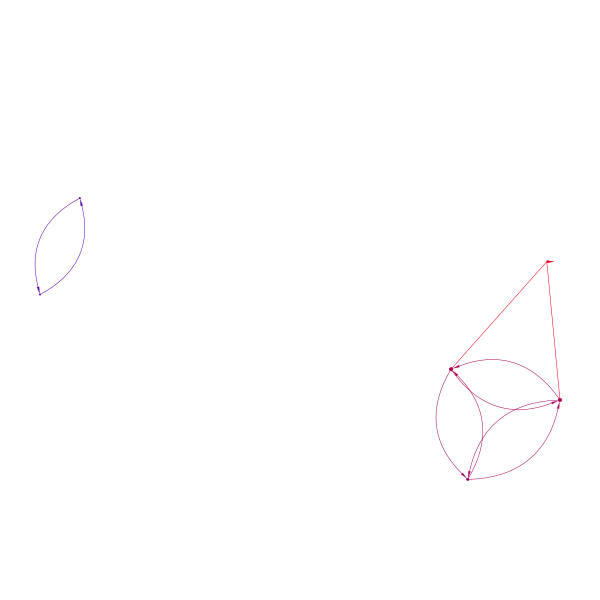

In [10]:
p